In [1]:
### General ###
import warnings
import numpy as np
import pandas as pd

### Machine Learning ###
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Optimization ###
import optuna

### Viz ###
from colorama import Fore

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [33]:
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [4]:
proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print('Proteins shape:',proteins.shape)
proteins.head()

Proteins shape: (232741, 5)


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [5]:
proteins_test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
print('Proteins test shape:',proteins_test.shape)
proteins_test.head()

Proteins test shape: (453, 6)


,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [6]:
peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print('Peptides shape:', peptides.shape)
peptides.head()

Peptides shape: (981834, 6)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [7]:
peptides_test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
print('Peptides test shape:', peptides_test.shape)
peptides_test.head()

Peptides test shape: (2057, 7)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [8]:
clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print('Clinical shape:', clinical.shape)
clinical.head()

Clinical shape: (2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [9]:
test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
print('Test shape:', test.shape)
test.head()

Test shape: (16, 6)


,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


In [10]:
proteins.groupby('visit_id').agg({'UniProt':'nunique','patient_id':'count','NPX':['min','max','mean','std']}).reset_index()

visit_id UniProt patient_id       NPX                             \
               nunique      count       min          max          mean   
0      10053_0     165        165  2497.840  269126000.0  2.856580e+06   
1     10053_12     171        171  5800.870  270030000.0  2.728871e+06   
2     10053_18     208        208  1334.110  278835000.0  2.509967e+06   
3     10138_12     217        217  2520.240  365582000.0  3.002583e+06   
4     10138_24     219        219  1436.940  396894000.0  3.068891e+06   
...        ...     ...        ...       ...          ...           ...   
1108   8699_24     216        216   756.551  346067000.0  3.064059e+06   
1109    942_12     212        212  1722.770  330558000.0  2.613298e+06   
1110    942_24     217        217  1339.150  336769000.0  2.616142e+06   
1111    942_48     216        216  1272.480  358059000.0  2.768442e+06   
1112     942_6     216        216  2491.690  290111000.0  2.476880e+06   

                    
               std  
0     2.131630e+07  
1     2.092162e+07  
2     1.969453e+07  
3     2.516170e+07  
4     2.716806e+07  
...            ...  
1108  2.409420e+07  
1109  2.295228e+07  
1110  2.312662e+07  
1111  2.460543e+07  
1112  2.002174e+07  

[1113 rows x 7 columns]

In [11]:
peptides.groupby('visit_id').agg({'UniProt':'nunique','patient_id':'count','Peptide':'nunique','PeptideAbundance': ['min','max','mean','std']}).reset_index()

visit_id UniProt patient_id Peptide PeptideAbundance               \
               nunique      count nunique              min          max   
0      10053_0     165        649     649          82.9679   66333900.0   
1     10053_12     171        633     633         128.4460   73059300.0   
2     10053_18     208        868     868         108.5000   64711200.0   
3     10138_12     217        932     932         129.0240   71652400.0   
4     10138_24     219        918     918         142.6480  123897000.0   
...        ...     ...        ...     ...              ...          ...   
1108   8699_24     216        911     911         106.9420   99846400.0   
1109    942_12     212        889     889          88.3277   70888500.0   
1110    942_24     217        910     910         108.7050   71995500.0   
1111    942_48     216        907     907         148.1360   70658500.0   
1112     942_6     216        918     918         158.8690   58472500.0   

                                   
               mean           std  
0     726248.393431  3.535602e+06  
1     737183.385744  3.799654e+06  
2     601466.784320  3.006568e+06  
3     699099.199189  3.379573e+06  
4     732120.888877  4.912602e+06  
...             ...           ...  
1108  726494.824901  4.080307e+06  
1109  623193.979635  3.362987e+06  
1110  623849.652027  3.294163e+06  
1111  659297.802601  3.359265e+06  
1112  582795.558517  2.734257e+06  

[1113 rows x 8 columns]

In [12]:
df_0 = clinical[(clinical.visit_month == 0)][['visit_id','updrs_1']]
print('Train shape:', df_0.shape)
df_0.head()

Train shape: (248, 2)


,visit_id,updrs_1
0,55_0,10.0
13,942_0,3.0
28,1517_0,11.0
38,1923_0,2.0
45,2660_0,2.0


In [13]:
proteins_npx_ft = proteins.groupby('visit_id').agg(NPX_min=('NPX','min'), NPX_max=('NPX','max'), NPX_mean=('NPX','mean'), NPX_std=('NPX','std'))\
                .reset_index()
proteins_npx_ft.head()

,visit_id,NPX_min,NPX_max,NPX_mean,NPX_std
0,10053_0,2497.84,269126000.0,2.856580e+06,2.131630e+07
1,10053_12,5800.87,270030000.0,2.728871e+06,2.092162e+07
2,10053_18,1334.11,278835000.0,2.509967e+06,1.969453e+07
3,10138_12,2520.24,365582000.0,3.002583e+06,2.516170e+07
4,10138_24,1436.94,396894000.0,3.068891e+06,2.716806e+07


In [14]:
df_proteins = pd.merge(proteins, df_0, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()
proteins_Uniprot_updrs.head()

,UniProt,updrs_1_sum
0,O00391,4.971014
1,O00533,5.319588
2,O00584,5.286458
3,O14498,5.217877
4,O14773,5.371585


In [15]:
df_proteins = pd.merge(proteins, proteins_Uniprot_updrs, on = 'UniProt', how = 'left')
proteins_UniProt_ft = df_proteins.groupby('visit_id').agg(proteins_updrs_1_min=('updrs_1_sum','min'), proteins_updrs_1_max=('updrs_1_sum','max'),\
                                                          proteins_updrs_1_mean=('updrs_1_sum','mean'), proteins_updrs_1_std=('updrs_1_sum','std'))\
                .reset_index()
proteins_UniProt_ft.head()

,visit_id,proteins_updrs_1_min,proteins_updrs_1_max,proteins_updrs_1_mean,proteins_updrs_1_std
0,10053_0,4.892857,5.601449,5.300548,0.077355
1,10053_12,4.816794,5.652174,5.296073,0.099055
2,10053_18,4.297619,5.652174,5.272617,0.134631
3,10138_12,4.297619,5.652174,5.263118,0.143238
4,10138_24,4.297619,5.652174,5.269522,0.137776


In [16]:
peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [17]:
peptides_PeptideAbundance_ft = peptides.groupby('visit_id').agg(Abe_min=('PeptideAbundance','min'), Abe_max=('PeptideAbundance','max'),\
                                                                Abe_mean=('PeptideAbundance','mean'), Abe_std=('PeptideAbundance','std'))\
                .reset_index()
peptides_PeptideAbundance_ft.head()

,visit_id,Abe_min,Abe_max,Abe_mean,Abe_std
0,10053_0,82.9679,66333900.0,726248.393431,3.535602e+06
1,10053_12,128.4460,73059300.0,737183.385744,3.799654e+06
2,10053_18,108.5000,64711200.0,601466.784320,3.006568e+06
3,10138_12,129.0240,71652400.0,699099.199189,3.379573e+06
4,10138_24,142.6480,123897000.0,732120.888877,4.912602e+06


In [18]:
df_peptides = pd.merge(peptides, df_0, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()
peptides_PeptideAbundance_updrs.head()

,Peptide,updrs_1_sum
0,AADDTWEPFASGK,5.357143
1,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,5.296703
2,AAFTEC(UniMod_4)C(UniMod_4)QAADK,5.305699
3,AANEVSSADVK,5.364780
4,AATGEC(UniMod_4)TATVGKR,5.146497


In [19]:
df_peptides = pd.merge(peptides, peptides_PeptideAbundance_updrs, on = 'Peptide', how = 'left')
peptides_ft = df_peptides.groupby('visit_id').agg(peptides_updrs_1_min=('updrs_1_sum','min'), peptides_updrs_1_max=('updrs_1_sum','max'),\
                                                          peptides_updrs_1_mean=('updrs_1_sum','mean'), peptides_updrs_1_std=('updrs_1_sum','std'))\
                .reset_index()
peptides_ft

,visit_id,peptides_updrs_1_min,peptides_updrs_1_max,peptides_updrs_1_mean,peptides_updrs_1_std
0,10053_0,4.878788,5.661972,5.279278,0.092880
1,10053_12,4.816794,5.661972,5.277513,0.097712
2,10053_18,4.297619,5.661972,5.265384,0.116303
3,10138_12,4.297619,5.661972,5.253513,0.126117
4,10138_24,4.297619,5.661972,5.257710,0.123452
...,...,...,...,...,...
1108,8699_24,4.572519,5.661972,5.256902,0.123395
1109,942_12,4.572519,5.661972,5.254323,0.118205
1110,942_24,4.572519,5.652174,5.255565,0.117226
1111,942_48,4.572519,5.652174,5.253489,0.119653


In [20]:
df_0_1 = clinical[(clinical.visit_month == 3)][['visit_id','updrs_1']]
df_0_2 = clinical[(clinical.visit_month == 3)][['visit_id','updrs_2']]
df_0_3 = clinical[(clinical.visit_month == 3)][['visit_id','updrs_3']]
df_0_4 = clinical[(clinical.visit_month == 3)][['visit_id','updrs_4']]

df_proteins = pd.merge(proteins, df_0_1, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs1 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()

df_proteins = pd.merge(proteins, df_0_2, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs2 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_2','mean')).reset_index()

df_proteins = pd.merge(proteins, df_0_3, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs3 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_3','mean')).reset_index()

df_proteins = pd.merge(proteins, df_0_4, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs4 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_4','mean')).reset_index()

df_peptides = pd.merge(peptides, df_0_1, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs1 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()

df_peptides = pd.merge(peptides, df_0_2, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs2 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_2','mean')).reset_index()

df_peptides = pd.merge(peptides, df_0_3, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs3 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_3','mean')).reset_index()

df_peptides = pd.merge(peptides, df_0_4, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs4 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_4','mean')).reset_index()

df_proteins_fts = [proteins_Uniprot_updrs1, proteins_Uniprot_updrs2, proteins_Uniprot_updrs3, proteins_Uniprot_updrs4]
df_peptides_fts = [peptides_PeptideAbundance_updrs1, peptides_PeptideAbundance_updrs2, peptides_PeptideAbundance_updrs3, peptides_PeptideAbundance_updrs4]
df_lst = [df_0_1, df_0_2, df_0_3, df_0_4]

In [21]:
def features(df, proteins, peptides, classes):
    proteins_npx_ft = proteins.groupby('visit_id').agg(NPX_min=('NPX','min'), NPX_max=('NPX','max'), NPX_mean=('NPX','mean'), NPX_std=('NPX','std'))\
                    .reset_index()
    peptides_PeptideAbundance_ft = peptides.groupby('visit_id').agg(Abe_min=('PeptideAbundance','min'), Abe_max=('PeptideAbundance','max'),\
                                                                    Abe_mean=('PeptideAbundance','mean'), Abe_std=('PeptideAbundance','std'))\
                    .reset_index()

    df_proteins = pd.merge(proteins, df_proteins_fts[classes], on = 'UniProt', how = 'left')
    proteins_UniProt_ft = df_proteins.groupby('visit_id').agg(proteins_updrs_1_min=('updrs_1_sum','min'), proteins_updrs_1_max=('updrs_1_sum','max'),\
                                                              proteins_updrs_1_mean=('updrs_1_sum','mean'), proteins_updrs_1_std=('updrs_1_sum','std'))\
                    .reset_index()
    df_peptides = pd.merge(peptides, df_peptides_fts[classes], on = 'Peptide', how = 'left')
    peptides_ft = df_peptides.groupby('visit_id').agg(peptides_updrs_1_min=('updrs_1_sum','min'), peptides_updrs_1_max=('updrs_1_sum','max'),\
                                                              peptides_updrs_1_mean=('updrs_1_sum','mean'), peptides_updrs_1_std=('updrs_1_sum','std'))\
                    .reset_index()

    df = pd.merge(df, proteins_npx_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, peptides_PeptideAbundance_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, proteins_UniProt_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, peptides_ft, on = 'visit_id', how = 'left')
    df = df.fillna(df.mean())
    return df

In [22]:
train_0 = features(df_0_1, proteins, peptides, 0)
train_0

,visit_id,updrs_1,NPX_min,NPX_max,NPX_mean,NPX_std,Abe_min,Abe_max,Abe_mean,Abe_std,proteins_updrs_1_min,proteins_updrs_1_max,proteins_updrs_1_mean,proteins_updrs_1_std,peptides_updrs_1_min,peptides_updrs_1_max,peptides_updrs_1_mean,peptides_updrs_1_std
0,55_3,10.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
1,942_3,7.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
2,3636_3,4.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
3,4161_3,1.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
4,5645_3,5.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,62723_3,7.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
111,62792_3,0.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
112,64669_3,15.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
113,64674_3,5.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0


In [23]:
def objective(trial):
    """
    Objective function to be passed to Optuna
    It also does Cross-Validation
    """
    args = {k: v for k, v in trial.params.items()}
    xgbr.set_params(**args)
        
    kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
    smape_scores = []
    for train_idx, val_idx in kf.split(train_0):
        X_train, y_train = train_0.iloc[train_idx].drop(columns=['visit_id', f'updrs_{i+1}']), train_0.iloc[train_idx][f'updrs_{i+1}']
        X_val, y_val = train_0.iloc[val_idx].drop(columns=['visit_id', f'updrs_{i+1}']), train_0.iloc[val_idx][f'updrs_{i+1}']
        xgbr.fit(X_train, y_train)
        smape_score = smape(y_val, xgbr.predict(X_val))
        smape_scores.append(smape_score)
    
    return np.mean(smape_scores)

**Note** 'updrs_3 is the same for all visited_id

In [25]:
updrs_3_pred = {}
up3 = clinical[['visit_month','updrs_3']].drop_duplicates(['visit_month','updrs_3'])
updrs_3_pred = dict(zip(up3.visit_month, up3.updrs_3))
updrs_3_pred

{0: 27.0,
 3: 31.0,
 6: 41.0,
 9: 31.0,
 12: 45.0,
 18: 14.0,
 24: 41.0,
 30: 38.0,
 36: 44.0,
 42: 48.0,
 48: 8.0,
 54: 57.0,
 60: 44.0,
 72: 51.0,
 84: 41.0,
 96: 5.0,
 108: 35.0}

In [26]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()
iter_test = env.iter_test()

In [27]:
def map_test(x):
    updrs = x.split('_')[2] + '_' + x.split('_')[3]
    month = int(x.split('_plus_')[1].split('_')[0])
    visit_id = x.split('_')[0] + '_' + x.split('_')[1]
    # set all predictions 0 where updrs equals 'updrs_4'
    if updrs=='updrs_3':
#         rating = updrs_3_pred[month]
        rating = df[df.visit_id == visit_id]['pred2'].values[0]
    elif updrs=='updrs_4':
        rating = 0
    elif updrs =='updrs_1':
        rating = df[df.visit_id == visit_id]['pred0'].values[0]
    else:
        rating = df[df.visit_id == visit_id]['pred1'].values[0]
    return rating

counter = 0
# The API will deliver four dataframes in this specific order:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    df = test[['visit_id']].drop_duplicates('visit_id')
    pred_0 = features(df[['visit_id']], test_proteins, test_peptides, 0)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_0[scale_col] = mms.fit_transform(pred_0[scale_col])
    pred_0 = model[0].predict(pred_0.drop(columns = ['visit_id'], axis = 1))
    df['pred0'] = np.ceil(pred_0 + 0.5)
    
    pred_1 = features(df[['visit_id']], test_proteins, test_peptides, 1)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_1[scale_col] = mms.fit_transform(pred_1[scale_col])
    pred_1 = model[1].predict(pred_1.drop(columns = ['visit_id'], axis = 1))
    df['pred1'] = np.ceil(pred_1 + 1)
    
    pred_2 = features(df[['visit_id']], test_proteins, test_peptides, 2)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_2[scale_col] = mms.fit_transform(pred_2[scale_col])
    pred_2 = model[2].predict(pred_2.drop(columns = ['visit_id'], axis = 1))
    df['pred2'] = np.ceil(pred_2 + 2)
    
    sample_submission['rating'] = sample_submission['prediction_id'].apply(map_test)
    env.predict(sample_submission)
    
    if counter == 0:
        display(test)
        display(sample_submission)
        
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_0,0,3342,updrs_1,3342_0_updrs_1
1,3342_0,0,3342,updrs_2,3342_0_updrs_2
2,3342_0,0,3342,updrs_3,3342_0_updrs_3
3,3342_0,0,3342,updrs_4,3342_0_updrs_4
4,50423_0,0,50423,updrs_1,50423_0_updrs_1
5,50423_0,0,50423,updrs_2,50423_0_updrs_2
6,50423_0,0,50423,updrs_3,50423_0_updrs_3
7,50423_0,0,50423,updrs_4,50423_0_updrs_4


,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,7.0
1,3342_0_updrs_1_plus_6_months,7.0
2,3342_0_updrs_1_plus_12_months,7.0
3,3342_0_updrs_1_plus_24_months,7.0
4,3342_0_updrs_2_plus_0_months,8.0
5,3342_0_updrs_2_plus_6_months,8.0
6,3342_0_updrs_2_plus_12_months,8.0
7,3342_0_updrs_2_plus_24_months,8.0
8,3342_0_updrs_3_plus_0_months,23.0
9,3342_0_updrs_3_plus_6_months,23.0


In [28]:
import shap


In [35]:
# Training loop with SHAP values
model = {}
mms = MinMaxScaler()
explainer_shap_values = {}

# Hyperparameters
params = {
    'n_estimators': [5, 20, 50, 100],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
}

for i in range(3):
    print('--------------------------------------------------------')
    print(g_, "#" * 17, "Model", y_, i + 1, g_, "#" * 17)

    train_0 = features(df_lst[i], proteins, peptides, i)
    scale_col = ['NPX_min', 'NPX_max', 'NPX_mean', 'NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    train_0[scale_col] = mms.fit_transform(train_0[scale_col])

    xgbr = xgb.XGBRegressor(random_state=42)

    # Defining the search space 
    space = [(k, v) for k, v in params.items()]

    # Bayesian Optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Best hyperparameters
    best_params = study.best_params
    xgbr.set_params(**best_params)
    X = train_0.drop(columns=['visit_id', f'updrs_{i+1}'])
    y = train_0[f'updrs_{i+1}']
    xgbr.fit(X, y)

    print(f"{b_}Train smape: {r_}{smape(y, xgbr.predict(X))}")
    print(f"{c_}Best params: {m_}{study.best_params}")
    print(g_, "#" * 45)

    model[i] = xgbr

    # Calculate SHAP values
    explainer = shap.TreeExplainer(xgbr)
    shap_values = explainer.shap_values(X)
    explainer_shap_values[i] = (explainer, shap_values, X)



--------------------------------------------------------
 ################# Model  1  #################
Train smape: 70.46046764737612
Best params: {}
 #############################################
--------------------------------------------------------
 ################# Model  2  #################
Train smape: 64.58294096939993
Best params: {}
 #############################################
--------------------------------------------------------
 ################# Model  3  #################
Train smape: 40.973712126490234
Best params: {}
 #############################################


In [36]:
# After the training loop, check the models
print("Models dictionary contents:", model)


Models dictionary contents: {0: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...), 1: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthw


Feature Importance for Model 1:


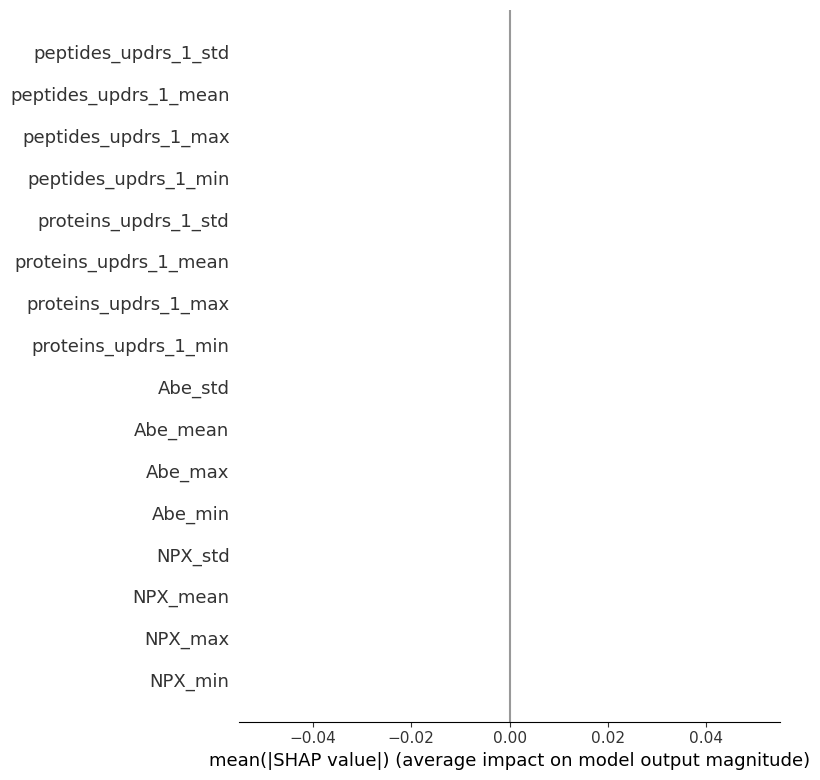

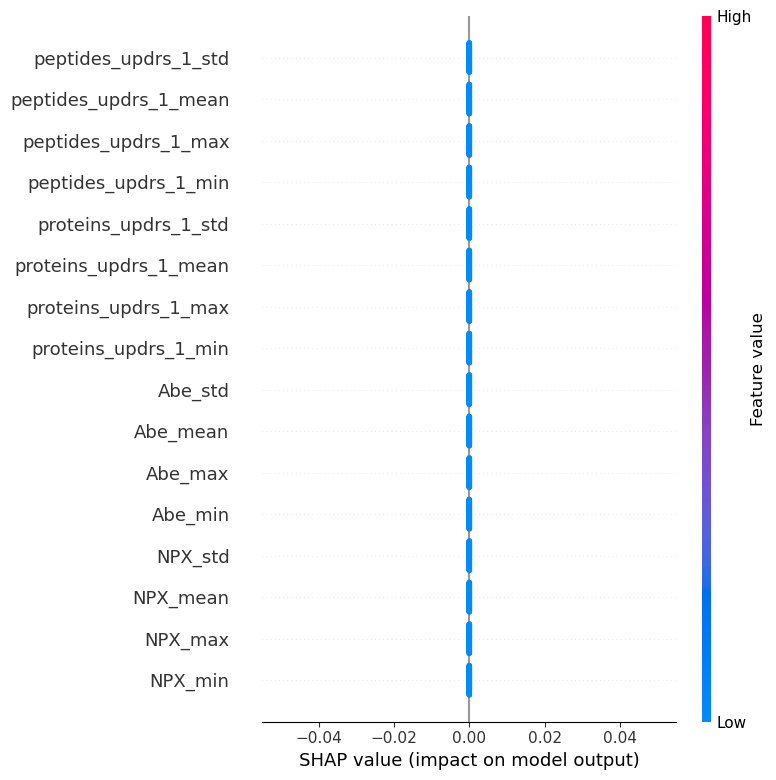


Feature Importance for Model 2:


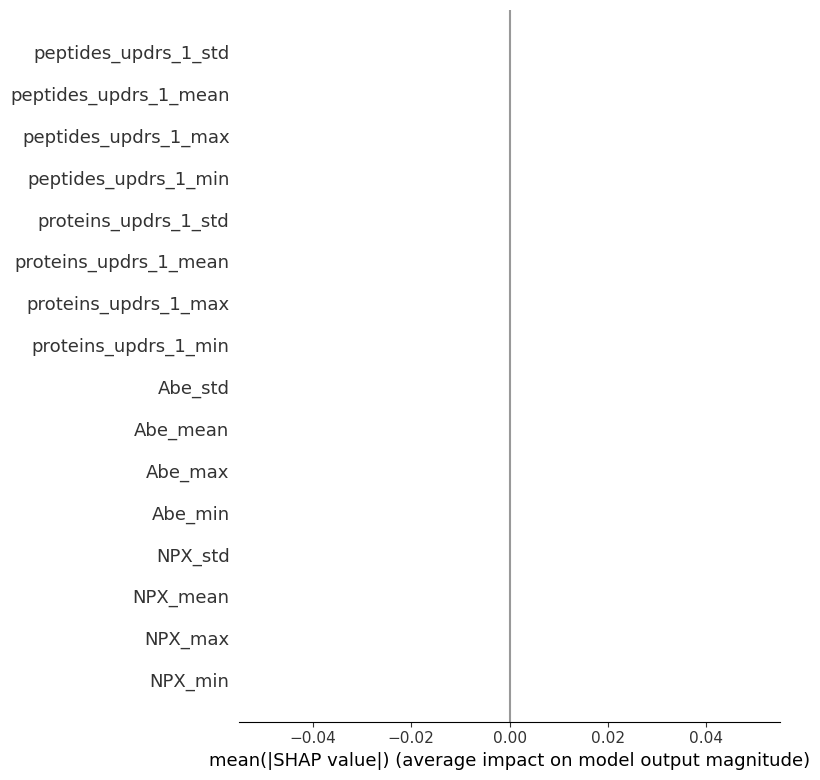

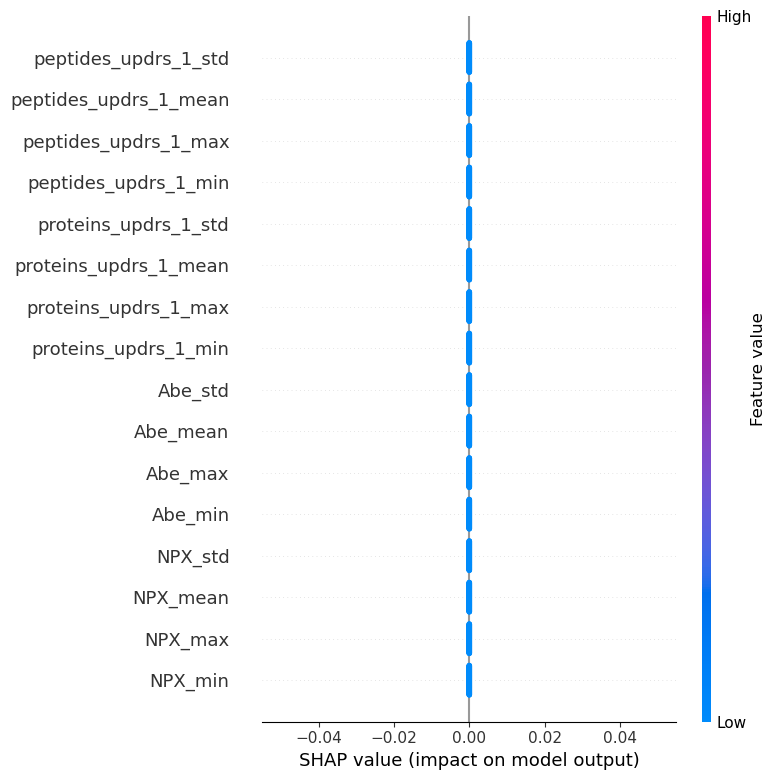


Feature Importance for Model 3:


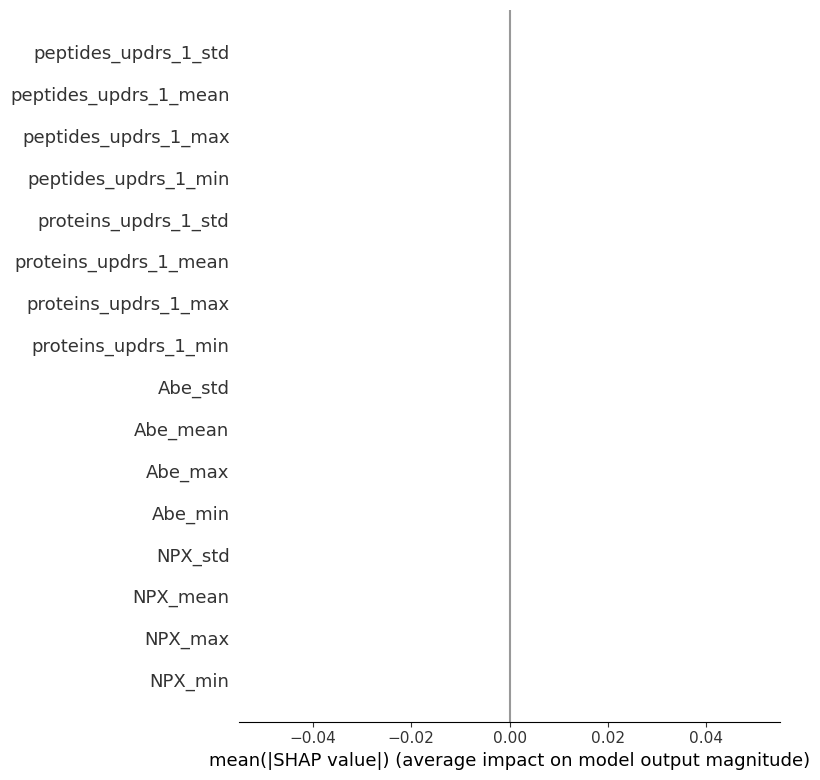

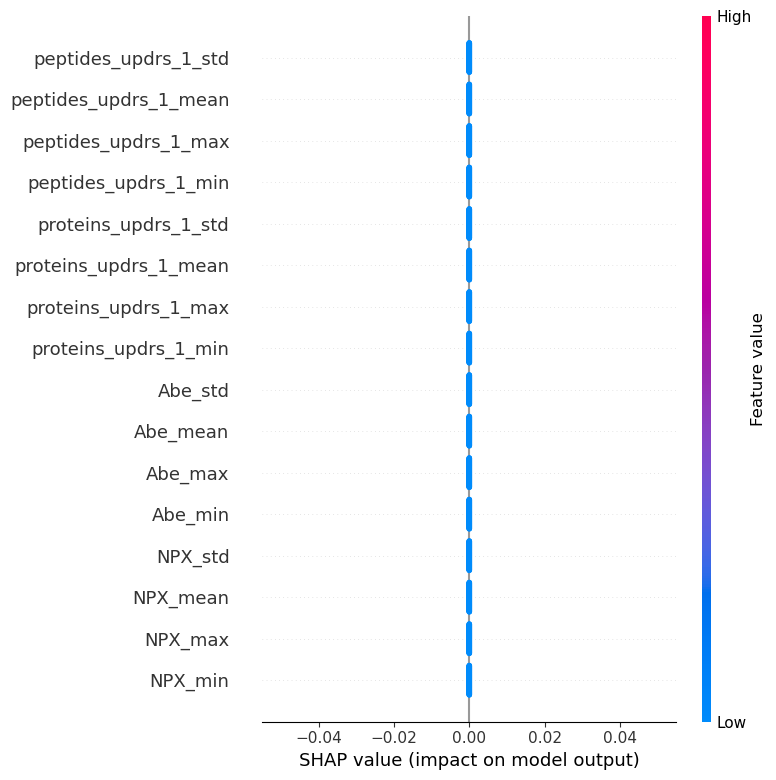

In [39]:
# Visualize SHAP values
for i in range(3):
    print(f"\nFeature Importance for Model {i+1}:")
    explainer, shap_values, X = explainer_shap_values[i]
    shap.summary_plot(shap_values, X, plot_type="bar")
    shap.summary_plot(shap_values, X)



Individual Prediction Explanation for Model 1:


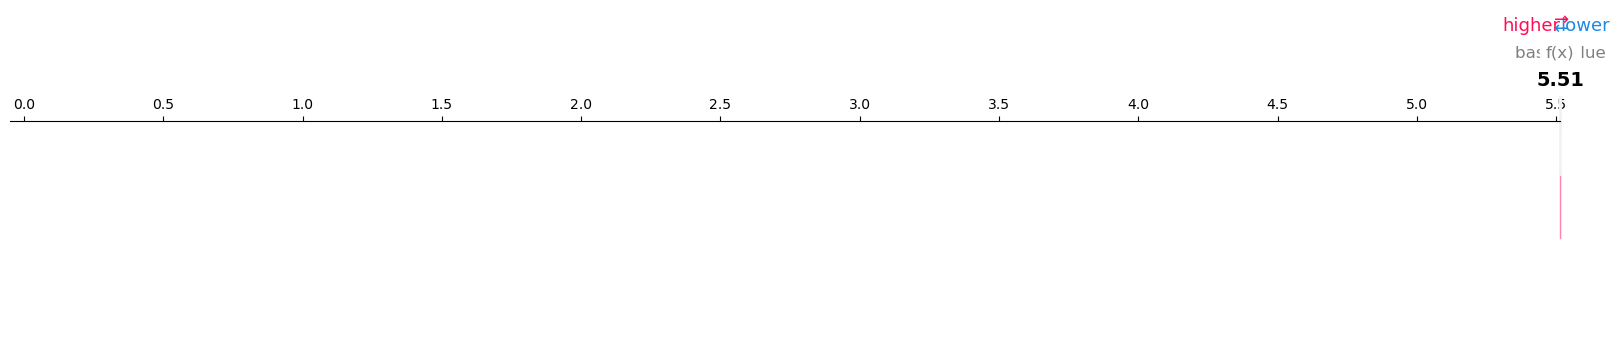


Individual Prediction Explanation for Model 2:


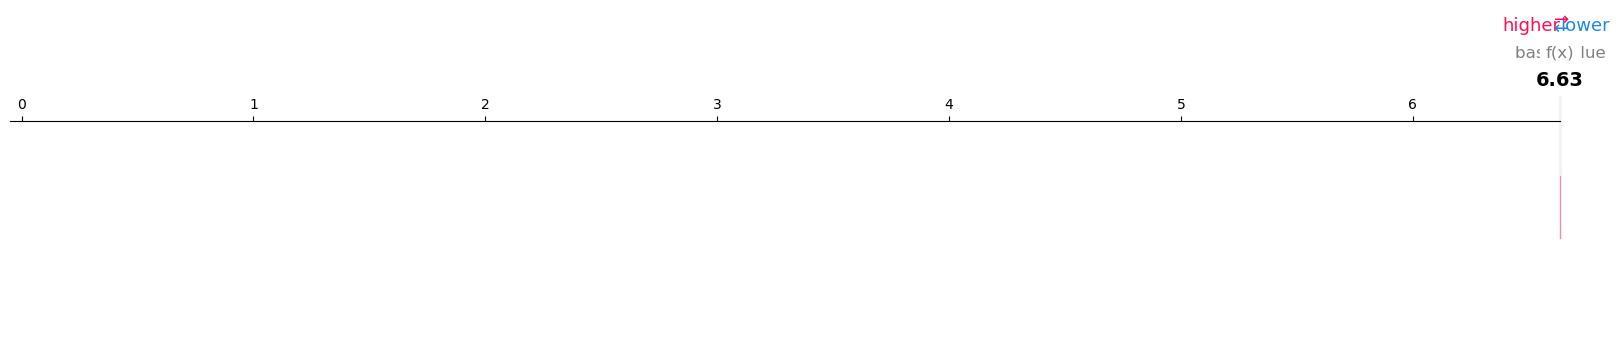


Individual Prediction Explanation for Model 3:


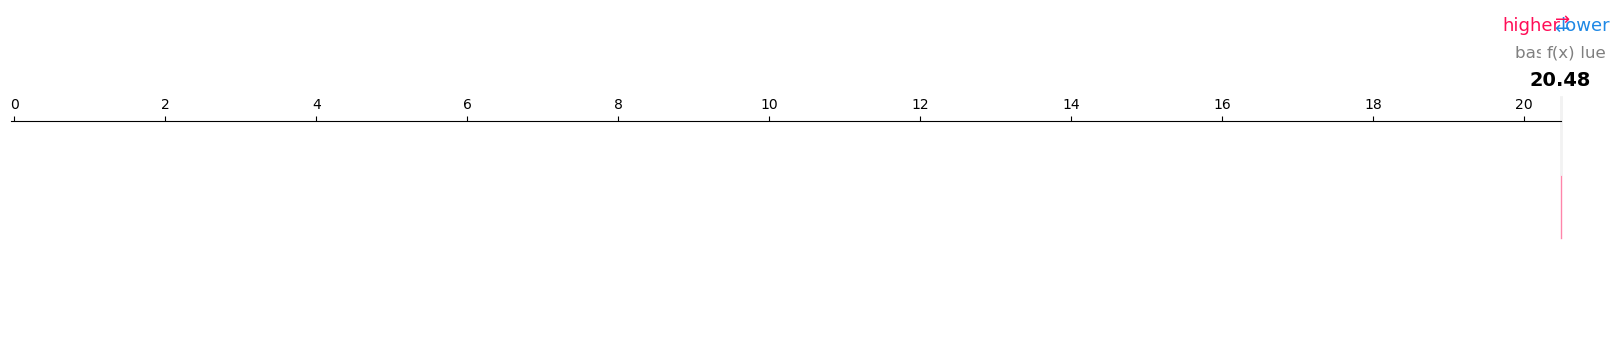

In [40]:
# Explain individual predictions
for i in range(3):
    print(f"\nIndividual Prediction Explanation for Model {i+1}:")
    explainer, shap_values, X = explainer_shap_values[i]
    # Example: Explain the first prediction
    shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)
